## Data Exploration

In [1]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime
program_start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print('Started: '+ program_start_time)

Started: 2020-05-18_16-36-36


### Load configuration

In [4]:
"""
Loads common configuration parameters
"""
from src.utils.configuration_manager import Config
from pathlib import PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = Config(config_path)

Loading configuration from: /home/justin/Code/interpretability_experiment/config.ini


### Start local Dask Client

In [5]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
    cluster = LocalCluster(dashboard_address=':20100', memory_limit='5G')
#     cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

Setting new client
<Client: 'tcp://127.0.0.1:41635' processes=5 threads=10, memory=25.00 GB>


Client Scheduler: tcp://127.0.0.1:41635 Dashboard: http://127.0.0.1:20100/status,Cluster Workers: 5 Cores: 10 Memory: 25.00 GB


### Prepare Dataset

In [6]:
"""
Loads the dataset file based on configuration 
"""
from src.preprocessing.dataset_manager import DatasetManager
dataset_manager = DatasetManager(config)

In [7]:
%time dataset_manager.write_dataset(overwrite=False)

Not overwriting existing training and test sets
CPU times: user 406 µs, sys: 56 µs, total: 462 µs
Wall time: 279 µs


In [8]:
ddf = dataset_manager.load_ddf()

In [9]:
ddf.npartitions

326

In [10]:
# ddf = ddf.repartition(npartitions=10000)

## Basic Data Statistics

In [11]:
ddf.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount_wo_tip             float64
tip_fraction                    float64
tipped                             bool
dtype: object

In [12]:
# %time ddf.describe().compute()

### OHE for categorical test

In [13]:
from dask_ml.preprocessing import OneHotEncoder

# init encoder
encoder = OneHotEncoder(sparse=False)

# Transform categories for Dask
# categorical_columns = ddf.select_dtypes(['category']).columns
categorical_columns = ['payment_type']
ddf[categorical_columns] = ddf[categorical_columns].categorize()

%time encoder.fit(ddf[categorical_columns])

CPU times: user 5.95 ms, sys: 4.08 ms, total: 10 ms
Wall time: 8.09 ms


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [14]:
# Transform to OHE
%time ddf_temp = encoder.transform(ddf[categorical_columns])

CPU times: user 8.49 ms, sys: 97 µs, total: 8.58 ms
Wall time: 7.01 ms


In [15]:
import dask.dataframe as dd
ddf = dd.concat([ddf, ddf_temp], axis=1)

/home/justin/.conda/envs/ml_env/lib/python3.7/site-packages/dask/dataframe/multi.py:1094: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [16]:
# Ignoring the warning message for now, the indices are the same in this case
%time correlations = ddf.corr().compute()

CPU times: user 36.3 s, sys: 3.92 s, total: 40.2 s
Wall time: 2min 57s


In [17]:
def prt_corr(correlations, targets):
    """
    Prints the correlations, ignoring correlations between target variables
    """
    for target in targets:
        print()
        inputs = [x for x in correlations.index if not x in config.targets]

        corr_temp = correlations[target][inputs]
        print(corr_temp)
    
prt_corr(correlations, config.targets)


passenger_count         -0.003554
trip_distance            0.113030
fare_amount              0.045267
extra                    0.076791
mta_tax                 -0.091437
tolls_amount             0.389426
improvement_surcharge    0.000342
total_amount_wo_tip      0.050178
payment_type_1           0.476373
payment_type_2          -0.468886
payment_type_3          -0.051849
payment_type_4          -0.027792
payment_type_5           0.000134
Name: tip_amount, dtype: float64

passenger_count         -0.002685
trip_distance            0.000392
fare_amount             -0.000354
extra                    0.000783
mta_tax                 -0.014493
tolls_amount             0.002404
improvement_surcharge    0.000096
total_amount_wo_tip     -0.000326
payment_type_1           0.122390
payment_type_2          -0.120488
payment_type_3          -0.013247
payment_type_4          -0.007024
payment_type_5          -0.000009
Name: tip_fraction, dtype: float64

passenger_count         -0.019394
trip_distan

Let's start by looking at the distribution of tipping behavior

In [63]:
import dask.array as da

def prt_distributions(target, bins, range_lst):
    h, bins = da.histogram(ddf[target], bins=bins, range=range_lst)
    hist_values = h.compute()
    print(bins)
    print(hist_values)
    
    bins = [round(x, 2) for x in bins]
    plt.bar(range(range_lst[0], range_lst[1]), hist_values)
    plt.xticks(range(0,20), bins, rotation='vertical')
    plt.ylabel('Transaction count')
    plt.xlabel(target)
    plt.title(target + 'including "no tip"')
    plt.show()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
[41032511 31289386 19598995  7927211  3576582  2436707  1322279  1093873
   892567   509164   745044   833729   276708   120189   195406   123364
    35193    62391    30550    37733]


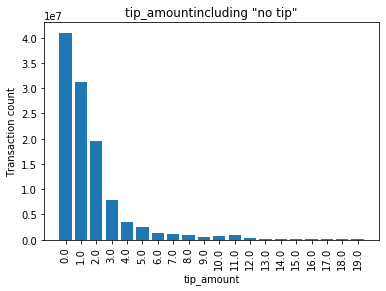

In [64]:
prt_distributions('tip_amount', bins=20, range_lst=[0,20])

In [98]:
import numpy as np

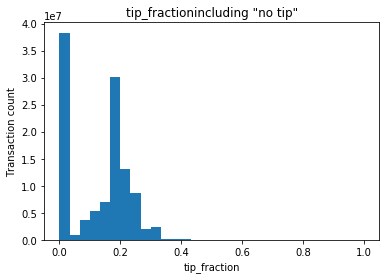

In [102]:
target = 'tip_fraction'

def get_hist_bins(target, bins, range_lst):
    h, bins = da.histogram(ddf[target], bins=bins, range=range_lst)
    hist_values = h.compute()
    return bins, hist_values

bins, hist = get_hist_bins(target, bins=30, range_lst=[0,1])

x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.ylabel('Transaction count')
plt.xlabel(target)
plt.title(target + ' distribution')

plt.bar(x, hist, width);

In [100]:
# bins, hist_values

In [101]:
# bins, hist

This could follow the total amounts pretty closely, let's check

In [22]:
import dask.array as da
h, bins = da.histogram(ddf['total_amount_wo_tip'], bins=30, range=[0, 100])
hist_values = h.compute()

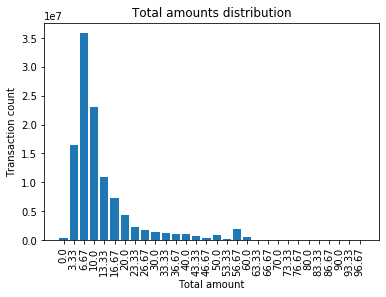

In [23]:
bins = [round(x, 2) for x in bins]
plt.bar(range(0,30), hist_values)
plt.xticks(range(0,30), bins, rotation='vertical')
plt.ylabel('Transaction count')
plt.xlabel('Total amount')
plt.title('Total amounts distribution')
plt.show()

These have similar distributions, perhaps there is some threshold point at which people feel more obliged to tip

## Seasonal trends

### Tip by location

In [24]:
pu_location = 'PULocationID'
do_location = 'DOLocationID'
tip = 'tip_amount'

In [25]:
tip_by_region = ddf.groupby(pu_location)[tip].mean()

In [26]:
tip_by_region.compute()

PULocationID
1      10.791346
10      6.435483
100     1.481584
101     1.403136
102     1.161811
         ...    
109     6.477368
110     1.185000
99      1.015000
199     3.179474
104     0.000000
Name: tip_amount, Length: 264, dtype: float64

### Tips by day of the week

In [27]:
# Using picking time as the timestamp
ts = 'tpep_pickup_datetime'

In [28]:
%time day_of_week_tips = ddf.groupby([ddf[ts].dt.dayofweek]).agg({tip: ['mean', 'std', 'count']}).compute()

CPU times: user 4.47 s, sys: 505 ms, total: 4.98 s
Wall time: 26 s


In [29]:
days_dict = {'Monday':0, 
             'Tuesday':1, 
             'Wednesday':2, 
             'Thursday':3, 
             'Friday':4, 
             'Saturday': 5, 
             'Sunday':6}

In [30]:
index_map = {y:x for x, y in days_dict.items()}
day_of_week_tips.index = day_of_week_tips.index.map(index_map)

In [31]:
print(day_of_week_tips)

                     tip_amount                    
                           mean       std     count
tpep_pickup_datetime                               
Monday                 1.899035  2.683273  14879162
Tuesday                1.920912  2.563087  15986547
Wednesday              1.932224  2.571662  16182062
Thursday               1.988110  2.675753  17174383
Friday                 1.898200  2.651803  17334732
Saturday               1.657446  2.391524  16550357
Sunday                 1.801010  2.706392  14127383


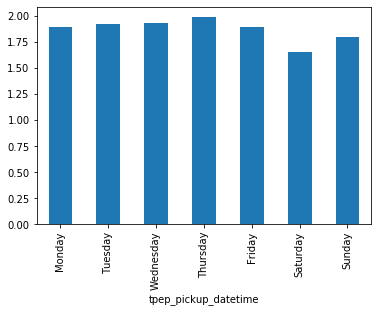

In [32]:
# import matplotlib.pyplot as plt
bar_plt = day_of_week_tips[('tip_amount','mean')].plot.bar()

<ErrorbarContainer object of 3 artists>

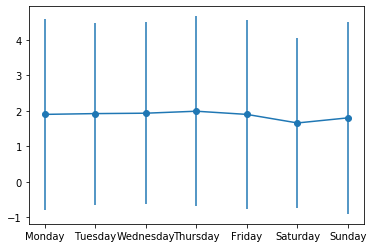

In [33]:
plt.scatter(day_of_week_tips.index, 
        day_of_week_tips[('tip_amount','mean')])
        
plt.errorbar(day_of_week_tips.index, 
             day_of_week_tips[('tip_amount','mean')],
             day_of_week_tips[('tip_amount','std')])

There appears to be lower tips on Saturdays. It would be interesting to compare what other factors might affect reported tips on that day

### Hourly trends during the week relative to Saturday and Sunday

In [34]:
%time monday_tips = ddf.groupby([ddf[ts].dt.dayofweek == 5]).agg({tip: ['mean', 'std', 'count']}).compute()

CPU times: user 4.58 s, sys: 520 ms, total: 5.1 s
Wall time: 25.9 s


In [35]:
print(monday_tips)

                     tip_amount                    
                           mean       std     count
tpep_pickup_datetime                               
False                  1.909667  2.641810  95684269
True                   1.657446  2.391524  16550357


Let's look at tiping behavior over the course of the year, averaging result by day

In [36]:
%time day_mean_tips = ddf.groupby([ddf[ts].dt.date])[tip].mean().compute()

CPU times: user 11.4 s, sys: 1.33 s, total: 12.7 s
Wall time: 2min 8s


In [37]:
print(day_mean_tips)

tpep_pickup_datetime
2009-01-01    1.394906
2018-11-07    2.069009
2018-12-01    1.707368
2018-12-02    1.817992
2018-12-03    2.030543
                ...   
2018-11-03    1.679070
2019-11-20    1.700000
2019-11-21    0.352000
2019-01-04    2.145000
2019-01-26    1.180000
Name: tip_amount, Length: 445, dtype: float64


In [38]:
"""
Cleanup and plot result
"""
day_mean_tips.sort_index(inplace=True)

In [39]:
import pandas as pd
# Transform indices back to datetime objects for filtering
day_mean_tips.index = pd.to_datetime(day_mean_tips.index.to_series())
# results = {index: row for index, row in day_mean_tips.iteritems() if index.year == 2018}

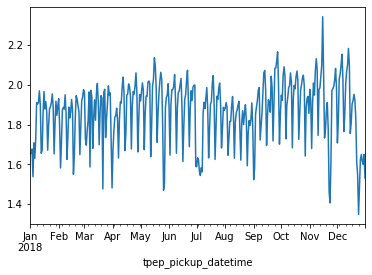

In [40]:
filtered_day_mean_tips = day_mean_tips[day_mean_tips.index.year == 2018]
filtered_day_mean_tips.plot()

#### Aggregate by week

In [41]:
%time weekly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.week]).mean()

CPU times: user 4.04 ms, sys: 471 µs, total: 4.52 ms
Wall time: 6.1 ms


(52,)


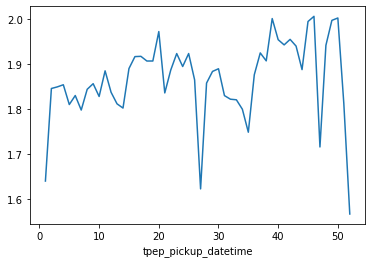

In [42]:
print(weekly_mean_tips.shape)
weekly_mean_tips.plot()

#### Aggregate by month

In [43]:
%time monthly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.month]).mean()

CPU times: user 2.75 ms, sys: 0 ns, total: 2.75 ms
Wall time: 2.45 ms


(12,)


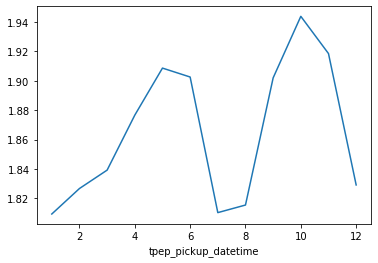

In [44]:
print(monthly_mean_tips.shape)
monthly_mean_tips.plot()

Seems there is some cyclicality to tipping (e.g., a spike in the fall/early winter months). We'd have to look at other things like the variance to gauge how meaninful this trend is. 